In [ ]:
import numpy as np
import transformers
import accelerate
#import vllm
import bitsandbytes
#from vllm import LLM, SamplingParams
import time
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib
from collections import Counter
import subprocess
import json


from sentence_transformers import SentenceTransformer, util
#matplotlib.use('TkAgg')
#from awq import AutoAWQForCausalLM
#from transformers import AutoTokenizer

# Modelle und Datensets needed:
Modelle:
+ https://huggingface.co/codellama/CodeLlama-7b-hf
+ https://huggingface.co/princeton-nlp/Sheared-LLaMA-1.3B
+ https://huggingface.co/tiiuae/falcon-rw-1b

+ llama/falcon 7b
ggf selber einmal finetunen ??


Task-to-Model Mapping: 

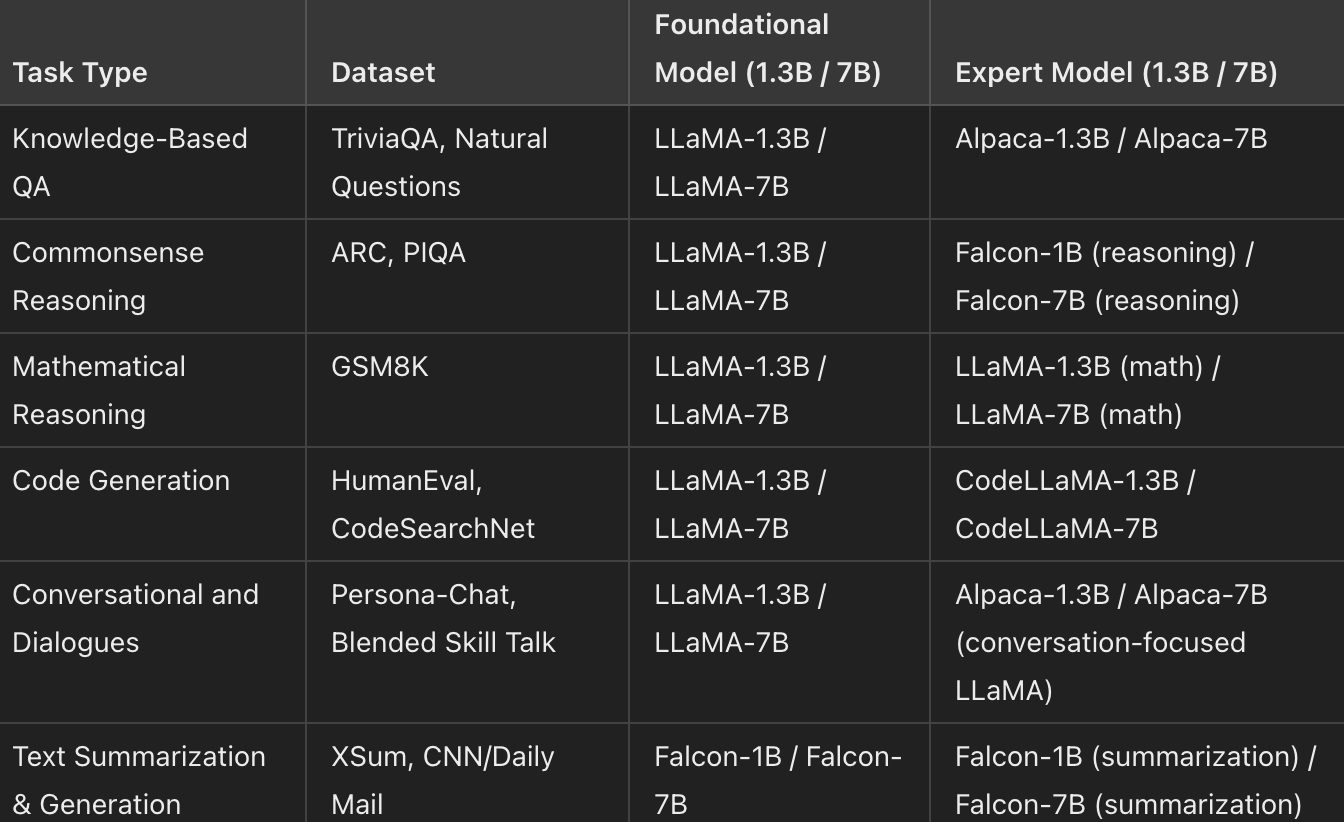

# Data Processing - Distance / Similiarity

"""
Multitask Benchmark datenset json

"""



import json
file_path = "question.jsonl"
with open(file_path, "r") as f:
    data = [json.loads(line) for line in f]
    #for line in f:
    #    data = json.loads(line)
    #    print(data)
df_mtconversation = pd.DataFrame(data)
df_mtconversation



In [ ]:
# Initialize the model
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Generate embeddings for each prompt
df_mtconversation['embeddings'] = df_mtconversation['text'].apply(lambda x: model.encode(x))


In [ ]:
from sklearn.cluster import KMeans
# Convert embeddings into a NumPy array for clustering
X = np.vstack(df_mtconversation['embeddings'].values)

# Initialize and fit K-Means
kmeans = KMeans(n_clusters=8, random_state=0)
df_mtconversation['cluster'] = kmeans.fit_predict(X)

# Check the clustering results
df_mtconversation[['text', 'category', 'cluster']].head(10)

In [ ]:
from sklearn.metrics import confusion_matrix
# Create a confusion matrix of true categories vs. clusters
conf_matrix = pd.crosstab(df_mtconversation['category'], df_mtconversation['cluster'])

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d")
plt.xlabel('Cluster')
plt.ylabel('Category')
plt.title('Category vs Cluster Confusion Matrix')
plt.show()

In [ ]:
# Calculate cluster centroids
cluster_centroids = []
for i in range(8):
    cluster_centroids.append(np.mean(X[df_mtconversation['cluster'] == i], axis=0))

# Compute cosine similarity between cluster centroids
similarity_matrix = cosine_similarity(cluster_centroids)

# Convert similarity matrix to a DataFrame for easy visualization
similarity_df = pd.DataFrame(similarity_matrix, index=[f"Cluster {i}" for i in range(8)], columns=[f"Cluster {i}" for i in range(8)])

# Plot the similarity matrix
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_df, annot=True, cmap="coolwarm", vmin=0, vmax=1)
plt.title("Cosine Similarity Between Cluster Centroids")
plt.show()


In [ ]:
from sklearn.manifold import TSNE
# Reduce dimensionality for visualization with t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_2d = tsne.fit_transform(X)

# Add the 2D embeddings to the DataFrame
df_mtconversation['x'] = X_2d[:, 0]
df_mtconversation['y'] = X_2d[:, 1]

# Plot the clusters in 2D space
plt.figure(figsize=(10, 8))
sns.scatterplot(x='x', y='y', hue='cluster', data=df_mtconversation, palette='viridis', legend='full')
plt.title("2D Visualization of Clusters with t-SNE")
plt.show()


In [ ]:
# Calculate average similarity of each point to its cluster centroid
intra_cluster_similarities = []
for i in range(8):
    cluster_points = X[df_mtconversation['cluster'] == i]
    centroid = cluster_centroids[i]
    similarities = cosine_similarity(cluster_points, [centroid])
    intra_cluster_similarities.append(similarities.mean())

# Print the intra-cluster similarity (compactness) for each cluster
for i, sim in enumerate(intra_cluster_similarities):
    print(f"Cluster {i} Intra-Cluster Similarity: {sim:.4f}")


In [ ]:
# Find closest clusters based on cosine similarity of centroids
# similarity_matrix is your cosine similarity matrix between cluster centroids

# Convert similarity matrix to a DataFrame for easy sorting and inspection
similarity_df = pd.DataFrame(similarity_matrix, index=[f"Cluster {i}" for i in range(8)], columns=[f"Cluster {i}" for i in range(8)])

# Get pairs of clusters and their similarity scores, excluding self-pairs
closest_pairs = []
for i in range(len(similarity_matrix)):
    for j in range(i+1, len(similarity_matrix)):
        closest_pairs.append((f"Cluster {i}", f"Cluster {j}", similarity_matrix[i][j]))

# Sort pairs by similarity score (highest first)
closest_pairs = sorted(closest_pairs, key=lambda x: x[2], reverse=True)

# Display closest cluster pairs
print("Closest Cluster Pairs by Cosine Similarity:")
for pair in closest_pairs[:5]:  # top 5 closest pairs
    print(f"{pair[0]} and {pair[1]} with similarity: {pair[2]:.4f}")


In [ ]:
# Display prompts and categories for the closest clusters
for cluster_name in [closest_pairs[0][0], closest_pairs[0][1]]:  # For top pair, adjust as needed
    cluster_number = int(cluster_name.split()[-1])
    print(f"\nPrompts in {cluster_name}:")
    display(df_mtconversation[df_mtconversation['cluster'] == cluster_number][['text', 'category']])


In [ ]:
# Step 1a: Identify the most cohesive cluster (highest intra-cluster similarity)
most_cohesive_cluster_id = np.argmax(intra_cluster_similarities)
print(f"Most cohesive cluster: Cluster {most_cohesive_cluster_id} with similarity {intra_cluster_similarities[most_cohesive_cluster_id]:.4f}")

# Step 1b: Identify the most distinct cluster from the cohesive one
# Use the similarity matrix to find the lowest similarity to the most cohesive cluster
similarities_to_cohesive = similarity_matrix[most_cohesive_cluster_id]
most_distinct_cluster_id = np.argmin(similarities_to_cohesive)
print(f"Most distinct cluster from Cluster {most_cohesive_cluster_id}: Cluster {most_distinct_cluster_id} with similarity {similarities_to_cohesive[most_distinct_cluster_id]:.4f}")


In [ ]:
# Step 1: Calculate similarity of each prompt to the centroid of Cluster 6
cluster_6_centroid = cluster_centroids[6]
all_similarities_to_cluster_6 = cosine_similarity(X, [cluster_6_centroid]).flatten()

# Step 2: Sort prompts by their similarity to Cluster 6's centroid and select the top 10 closest prompts
df_mtconversation['similarity_to_cluster_6'] = all_similarities_to_cluster_6
closest_to_cluster_6 = df_mtconversation.sort_values(by='similarity_to_cluster_6', ascending=False).head(10)

# Display the 10 most similar prompts for Cluster 6
print("10 Closest Prompts to Cluster 6:")
display(closest_to_cluster_6[['text', 'category', 'similarity_to_cluster_6']])

# Step 3: Retrieve 10 most distinct prompts from the most distinct cluster
# Assuming we already identified the most distinct cluster as `most_distinct_cluster_id`
most_distinct_prompts = df_mtconversation[df_mtconversation['cluster'] == most_distinct_cluster_id].head(10)

print("\n10 Most Distinct Prompts from the Most Distinct Cluster:")
display(most_distinct_prompts[['text', 'category']])


In [ ]:
# Retrieve the text of prompts in each DataFrame for comparison
closest_texts = set(closest_to_cluster_6['text'])
distinct_texts = set(most_distinct_prompts['text'])

# Find the intersection of both sets
overlap = closest_texts.intersection(distinct_texts)

# Display result based on whether overlap exists
if overlap:
    print("Overlap detected! These prompts appear in both sets:")
    print(overlap)
else:
    print("No overlap detected. The 'closest to Cluster 6' and 'most distinct' prompts are mutually exclusive.")


# Finetuned Model and foundational Model for Embedding: Closest and most distinct prompts

using expert for embedding to identify prompts/tasks which are the "easiest" for them ??

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

# Load the finetuned and foundational models
finetuned_model_name = "distilgpt2"  # Replace with your model's name
foundational_model_name = "facebook/opt-125m" # Replace with your foundational model's name

# Load tokenizer and models
tokenizer_finetuned = AutoTokenizer.from_pretrained(finetuned_model_name)
model_finetuned = AutoModel.from_pretrained(finetuned_model_name)

tokenizer_foundational = AutoTokenizer.from_pretrained(foundational_model_name)
model_foundational = AutoModel.from_pretrained(foundational_model_name)

# Define task-specific anchor text representing the core task
task_anchor_text = "Summarize the following text:"  # Change based on task
inputs = tokenizer_finetuned(task_anchor_text, return_tensors="pt")
with torch.no_grad():
    task_embedding = model_finetuned(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()


In [ ]:
# Compute embeddings for each prompt using the finetuned model
prompt_embeddings = []
for text in df_mtconversation['text']:
    inputs = tokenizer_finetuned(text, return_tensors="pt")
    with torch.no_grad():
        embedding = model_finetuned(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()
    prompt_embeddings.append(embedding)

# Store the embeddings in the DataFrame
df_mtconversation['finetuned_embeddings'] = prompt_embeddings


In [ ]:
# Calculate cosine similarity of each prompt to the task embedding
similarities = [cosine_similarity([embedding], [task_embedding])[0][0] for embedding in prompt_embeddings]
df_mtconversation['similarity_to_task'] = similarities

# Sort prompts by similarity to task embedding
easiest_prompts = df_mtconversation.sort_values(by='similarity_to_task', ascending=False).head(10)
most_distinct_prompts = df_mtconversation.sort_values(by='similarity_to_task', ascending=True).head(10)

# Display results
print("\nEasiest Prompts (Most Similar to Task):")
display(easiest_prompts[['text', 'category', 'similarity_to_task']])

print("\nMost Distinct Prompts (Least Similar to Task):")
display(most_distinct_prompts[['text', 'category', 'similarity_to_task']])
